In [310]:
%pylab inline
import xarray as xr
from tqdm import tqdm_notebook
import cmocean.cm as cmo

plt.rcParams['figure.figsize'] = (18,10)
plt.rcParams['font.size'] = 16
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['xtick.direction'] = 'out'

font = {'family' : 'Arial',
        'weight' : 'ultralight',
        'size'   : 16}

matplotlib.rc('font', **font)

rc('ytick.major', size=6)
rc('xtick.major', size=6)
rc('ytick.minor', size=4)
rc('xtick.minor', size=4)
rc('lines', linewidth=2.5)

Populating the interactive namespace from numpy and matplotlib


### Find all the argo profiles that were present during our deployment period

In [286]:
en4 = xr.open_mfdataset('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/data/EN4.2.1/Profiles_L09_2018_19/*.nc')

In [287]:
ind = ((en4.LATITUDE.values<0) & (en4.LONGITUDE.values>-60) & (en4.LONGITUDE.values<50))

en4_sub = en4.isel(N_PROF=en4.N_PROF[ind].values)

In [288]:
max_lat=-30
min_lat=-70
max_lon= 10
min_lon= -5

ind_GH = ((en4_sub.LATITUDE.values<max_lat) & (en4_sub.LATITUDE.values>min_lat) & (en4_sub.LONGITUDE.values>min_lon) & (en4_sub.LONGITUDE.values<max_lon) & (en4_sub.QC_FLAGS_PROFILES.values==0))

en4_GH = en4_sub.isel(N_PROF=en4_sub.N_PROF[ind_GH].values)

In [289]:
from scipy.interpolate import griddata

In [346]:
import time

new_depth = np.arange(0, 1010, 10)

temp = np.ndarray([len(en4_GH.JULD), len(new_depth)])
salt = np.ndarray([len(en4_GH.JULD), len(new_depth)])

temp_old = en4_GH.TEMP.values
salt_old = en4_GH.PSAL_CORRECTED.values
depth_old = en4_GH.DEPH_CORRECTED.values

for i in range(len(temp_old)):
    
    temp[i] = griddata(depth_old[i], temp_old[i], new_depth)
    salt[i] = griddata(depth_old[i], salt_old[i], new_depth)

time.sleep(2)

In [347]:
i = np.argsort(en4_GH.LATITUDE.values)

lats = en4_GH.LATITUDE.values[i]
lons = en4_GH.LONGITUDE.values[i]
temp = temp[i]
salt = salt[i]

Quality control, removes bad data

In [348]:
i = ((salt[:, 40] > 33) & (temp[:, 13] < 30))

salt = salt[i]
temp = temp[i]
lats = lats[i]
lons = lons[i]

Converting practical to absolute salinity

In [352]:
import gsw

salt_abs = np.ndarray([len(lats), len(new_depth)])

for i in range(101):

    salt_abs[:, i] = gsw.SA_from_SP(salt[:, i], p=0, lon=lons, lat=lats)
    
salt = salt_abs

Grid data to 0.5 deg latitude bins

In [502]:
temp.shape

(4177, 101)

In [503]:
lats.shape

(4177,)

In [508]:
import time

new_lats = np.arange(-70, -29.9, 0.05)

temp_grid = np.ndarray([len(new_lats), len(new_depth)])
salt_grid = np.ndarray([len(new_lats), len(new_depth)])

for i in range(len(new_depth)):
    
    temp_grid[:, i] = griddata(lats, temp[:, i], new_lats)
    salt_grid[:, i] = griddata(lats, salt[:, i], new_lats)

time.sleep(2)

In [294]:
import glidertools as gt

#### Calculate the density from the T and S

In [510]:
dens = gsw.rho(salt_grid, temp_grid, p=0)

Text(-41.5, 380, 'Density (kg m$^{-3}$)')

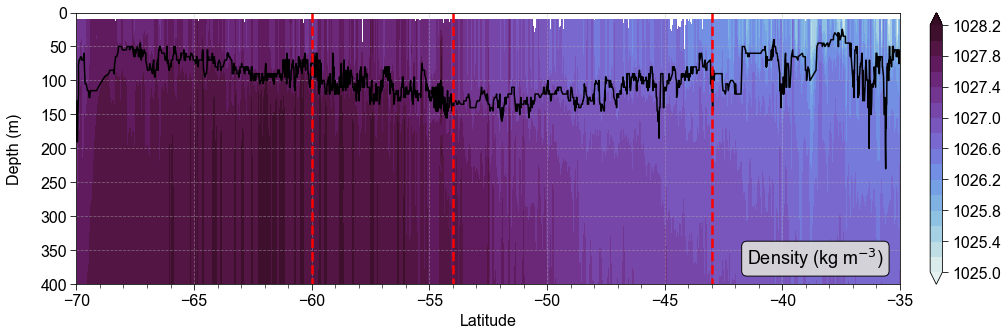

In [512]:
fig, ax = subplots(figsize=[18, 5])

h1 = ax.contourf(new_lats, new_depth, dens.T, levels=np.arange(1025, 1028.2, 0.2), cmap=cmo.dense, extend='both')

colorbar(mappable=h1, ax=ax, pad=0.03)

ax.set_ylim(400, 0)
ax.set_xticks(np.arange(-70, -30, 1), minor=True)
ax.set_xlim(-70, -35) 
ax.grid(ls='--', alpha=0.5)

ax.plot(lats, mld_new, c='k', lw=1.5)

ax.plot([-60, -60], [0, 400], c='r', ls='--') 
ax.plot([-54, -54], [0, 400], c='r', ls='--') 
ax.plot([-43, -43], [0, 400], c='r', ls='--') 

ax.set_ylabel('Depth (m)', labelpad=18) 

ax.set_xlabel('Latitude')

props = dict(boxstyle='round', facecolor='0.85', alpha=0.95)

# place a text box in upper left in axes coords
ax.text(-41.5, 380, 'Density (kg m$^{-3}$)', fontsize=18,
        verticalalignment='bottom', bbox=props)



Calculate MLD

In [513]:
def calc_mld(dens, depth, thres=0.1):
    
    mld = np.ndarray(len(dens))
    
    for i in range(len(dens)):
        
        mld[i] = gt.physics.mixed_layer_depth(np.tile(0, 101), depth, dens[i], thresh=thres, ref_depth=20)
        
    return mld

In [514]:
mld = calc_mld(dens, new_depth)

In [533]:
mld_new = gt.cleaning.rolling_window(mld, func=np.nanmedian, window=4)

/Users/marcel/anaconda3/lib/python3.7/site-packages/glidertools/helpers.py:61: GliderToolsWarning: Primary input variable is not xr.DataArray data type - no metadata to pass on.
  warnings.warn(msg, category=GliderToolsWarning)


(1000, 0)

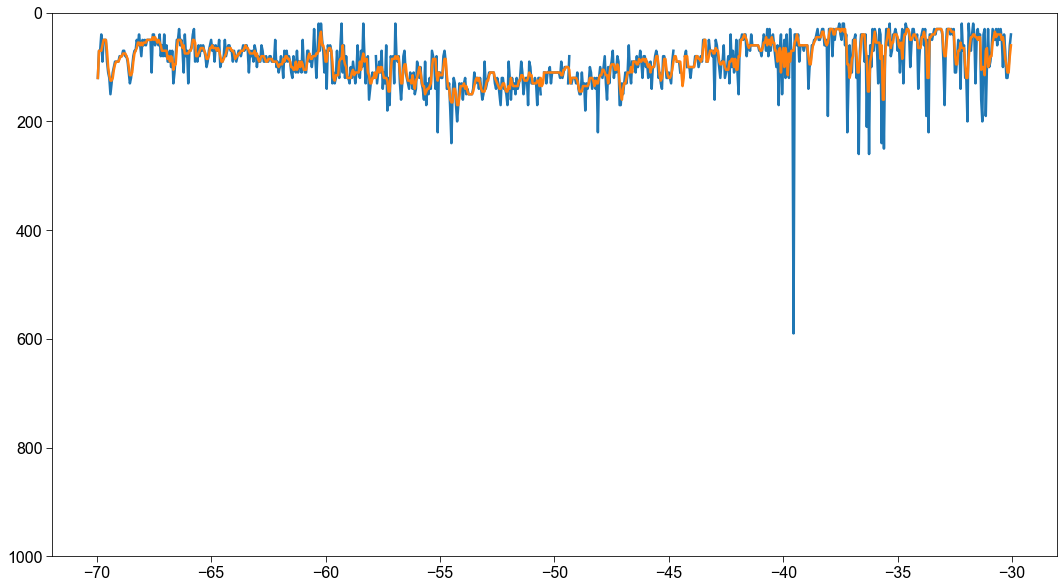

In [534]:
plot(new_lats, mld)
plot(new_lats, mld_new)

ylim(1000, 0)

In [520]:
dens_clean = np.ndarray(shape(dens))

for i in range(100):
    
    dens_clean[:,i] = gt.cleaning.rolling_window(dens[:,i], func=np.nanmedian, window=10)
#     dens_clean[:,i] = gt.cleaning.savitzky_golay(dens[:,i], window_size=35, order=11)


/Users/marcel/anaconda3/lib/python3.7/site-packages/glidertools/helpers.py:61: GliderToolsWarning: Primary input variable is not xr.DataArray data type - no metadata to pass on.
  warnings.warn(msg, category=GliderToolsWarning)


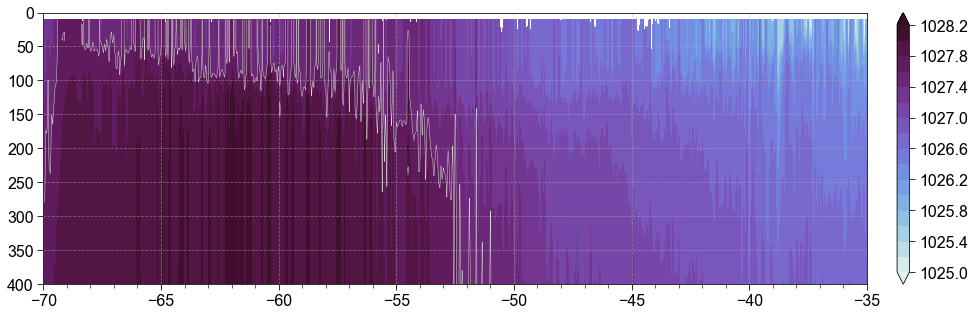

In [522]:
fig, ax = subplots(figsize=[18, 5])

h1 = ax.contourf(new_lats, new_depth, dens.T, levels=np.arange(1025, 1028.2, 0.2), cmap=cmo.dense, extend='both')

colorbar(mappable=h1, ax=ax, pad=0.03)

ax.set_ylim(400, 0)
ax.set_xticks(np.arange(-70, -30, 1), minor=True)
ax.set_xlim(-70, -35) 
ax.grid(ls='--', alpha=0.5)

ax.contour(new_lats, new_depth, dens.T, levels=[1027.6], colors='0.85', linewidths=0.5)


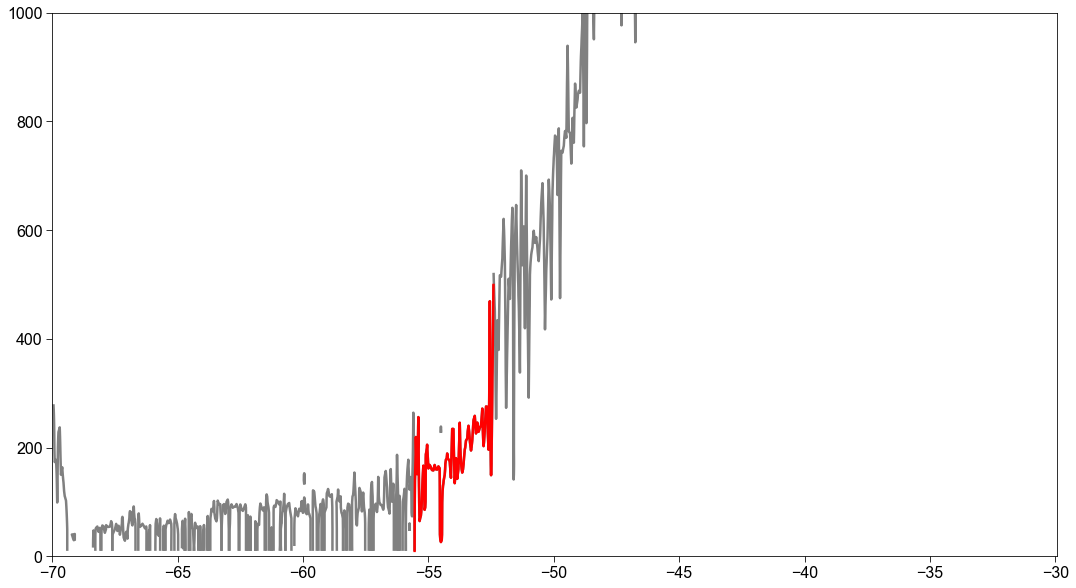

In [567]:
CS=contour(new_lats, new_depth, dens.T, levels=[1027.6], colors='0.5')
dat0 = CS.allsegs[0][47]
plt.plot(dat0[:,0],dat0[:,1], c='r')
si = dat0

In [579]:
for i in range(len(CS.allsegs[0])):
    
    if i==0:
        lt = CS.allsegs[0][i][:,0]
        dp = CS.allsegs[0][i][:,1]
        
    if i>0:
        
        lt = np.append(lt, CS.allsegs[0][i][:,0])
        dp = np.append(dp, CS.allsegs[0][i][:,1])
    

In [583]:
i = np.argsort(lt)

lt = lt[i]
dp = dp[i]

In [588]:
lt_new = np.arange(-70, -39, 0.1)
dp_new = griddata(lt, dp, lt_new)

/Users/marcel/anaconda3/lib/python3.7/site-packages/glidertools/helpers.py:61: GliderToolsWarning: Primary input variable is not xr.DataArray data type - no metadata to pass on.
  warnings.warn(msg, category=GliderToolsWarning)


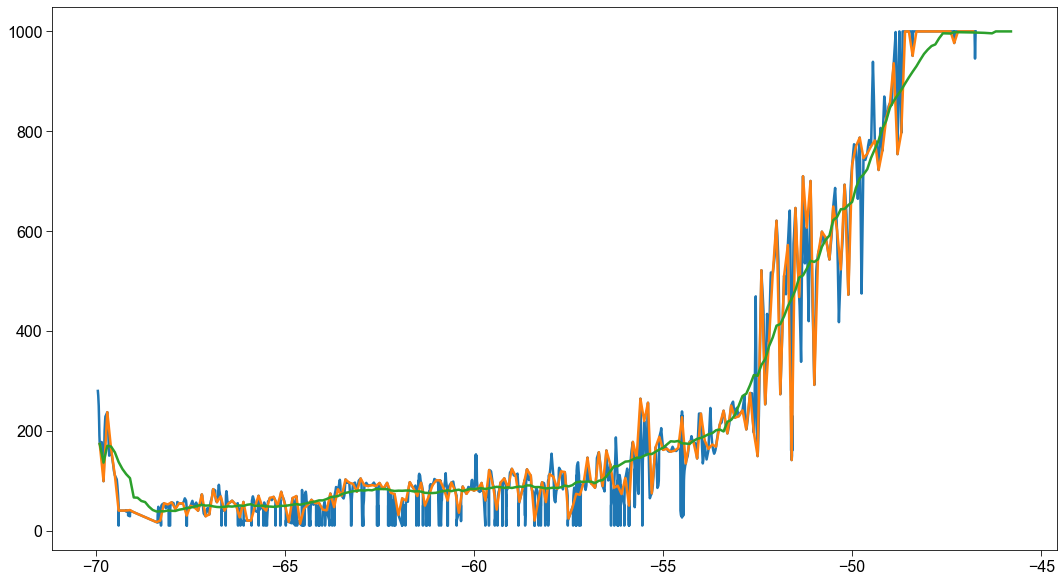

In [590]:
plot(lt, dp)
plot(lt_new, dp_new)
plot(lt_new, gt.cleaning.rolling_window(dp_new, func=np.nanmean, window=20))

### Plot the sections

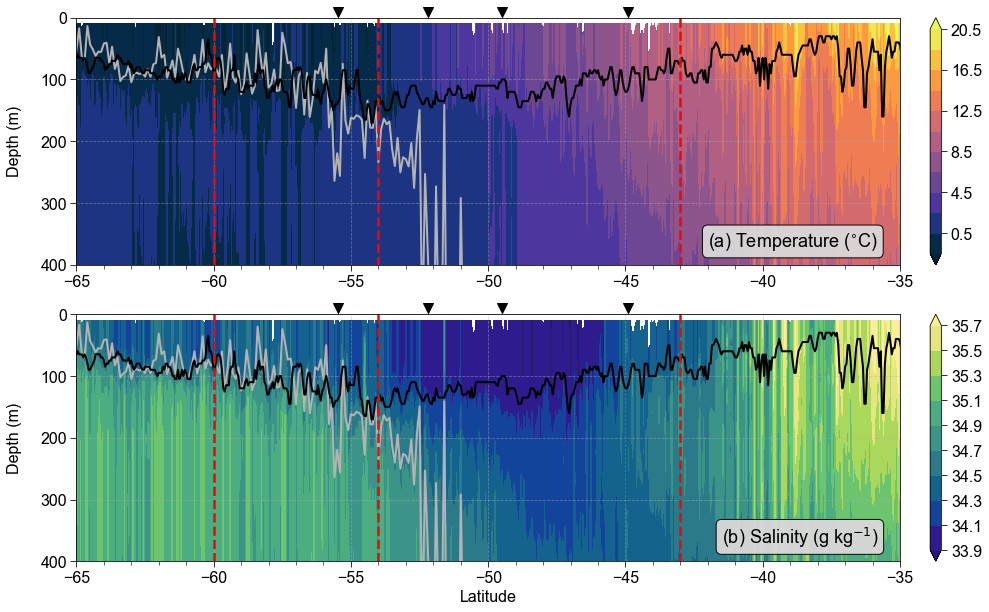

In [606]:
fig, ax = subplots(2)

h0 = ax[0].contourf(new_lats, new_depth, temp_grid.T, levels=np.arange(-1.5, 22.5, 2), cmap=cmo.thermal, extend='both')
h1 = ax[1].contourf(new_lats, new_depth, salt_grid.T, levels=np.arange(33.9, 35.9, 0.2), cmap=cmo.haline, extend='both')

colorbar(mappable=h0, ax=ax[0], pad=0.03)
colorbar(mappable=h1, ax=ax[1], pad=0.03)

# [a.contour(new_lats, new_depth, dens.T, levels=[1027.6], colors='0.7', linewidths=1.5) for a in ax]
# [a.plot(lt_new, gt.cleaning.rolling_window(dp_new, func=np.nanmin, window=3), color='0.7', linewidth=3) for a in ax]
[a.plot(lt_new, dp_new, color='0.7', linewidth=2) for a in ax]

[a.set_ylim(400, 0) for a in ax]
[a.set_xticks(np.arange(-70, -30, 1), minor=True) for a in ax]
[a.set_xlim(-65, -35) for a in ax]
[a.grid(ls='--', alpha=0.5) for a in ax]

[a.plot(new_lats, mld_new, c='k', lw=2) for a in ax] # mixed layer depth

[a.plot([-60, -60], [0, 400], c='r', ls='--') for a in ax]
[a.plot([-54, -54], [0, 400], c='r', ls='--') for a in ax]
[a.plot([-43, -43], [0, 400], c='r', ls='--') for a in ax]

[a.set_ylabel('Depth (m)', labelpad=18) for a in ax]

ax[1].set_xlabel('Latitude')

# fig.tight_layout()

props = dict(boxstyle='round', facecolor='0.85', alpha=0.95)

# place a text box in upper left in axes coords
ax[0].text(-42, 380, '(a) Temperature ($^{\circ}$C)', fontsize=18,
        verticalalignment='bottom', bbox=props)
ax[1].text(-41.5, 380, '(b) Salinity (g kg$^{-1}$)', fontsize=18,
        verticalalignment='bottom', bbox=props)

h= ax[0].scatter([-55.47, -52.2, -49.5, -44.9], [-10, -10, -10, -10], s=100, marker='v', c='k', zorder=10)
h.set_clip_on(False)

h= ax[1].scatter([-55.47, -52.2, -49.5, -44.9], [-10, -10, -10, -10], s=100, marker='v', c='k', zorder=10)
h.set_clip_on(False)

savefig('/Users/marcel/Google Drive/Projects/buoyancy_flux_paper/figures/en4_sections.png', dpi=300, bbox_inches='tight')